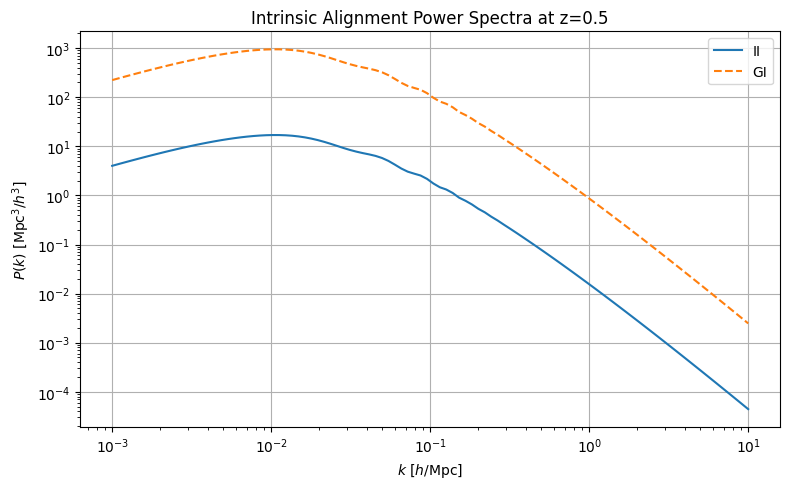

In [5]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

# 1. Define cosmology
cosmo = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96
)

# 2. Define redshift and scale
z = 0.5
a = 1 / (1 + z)
k = np.logspace(-3, 1, 100)  # in h/Mpc

# 3. Linear matter power spectrum (or nonlinear)
pk_m = ccl.linear_matter_power(cosmo, k, a)  # or use nonlinear_matter_power

# 4. Intrinsic Alignment model parameters
# C_1 * rho_crit ~ 0.0134 in h^-2 M_sun / Mpc^3 (Bridle & King 2007)
# But in pyccl, C1 is usually passed dimensionlessly as C1 ~ 5e-14 (for C1*rho_crit)
C1 = 5e-14  # In units of (Mpc/h)^3 / M_sun
rho_crit = ccl.physical_constants.RHO_CRITICAL  # in M_sun / Mpc^3
D = ccl.growth_factor(cosmo, a)

# 5. Compute IA amplitude
A_IA = 1.0  # Fiducial amplitude
F_IA = -A_IA * C1 * rho_crit / D  # LA model

# 6. Compute IA power spectra
P_II = F_IA**2 * pk_m
P_GI = F_IA * pk_m

# 7. Plot
plt.figure(figsize=(8, 5))
plt.loglog(k, P_II, label="II")
plt.loglog(k, np.abs(P_GI), label="GI", ls="--")
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$P(k)$ [Mpc$^3/h^3$]")
plt.title(f"Intrinsic Alignment Power Spectra at z={z}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_221948/1613655176.py:45: SyntaxWarning: invalid escape sequence '\p'
  plt.title('IA Correlation Function $\\xi_{II}(r_p, \pi)$')


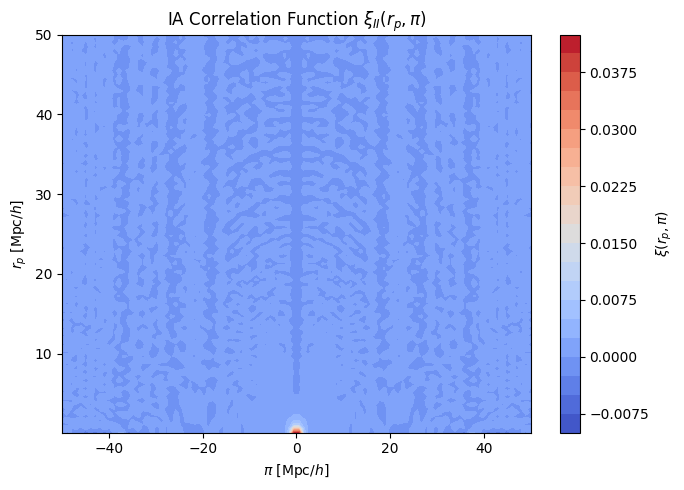

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.integrate import simpson

# Grid setup
k = np.logspace(-3, 1, 200)  # h/Mpc
mu = np.linspace(-1, 1, 100)
k2d, mu2d = np.meshgrid(k, mu, indexing='ij')

# Assume P(k, mu) = P(k) (i.e., isotropic), for II or GI IA spectra
# Use P_II or P_GI from previous step
P_k = F_IA**2 * ccl.nonlin_matter_power(cosmo, k, a)  # for NLA model
Pkm = np.tile(P_k[:, None], (1, len(mu)))  # broadcast to (k, mu)

# Create r_p and pi grid (in Mpc/h)
rp_vals = np.linspace(0.1, 50, 100)
pi_vals = np.linspace(-50, 50, 100)
rp_grid, pi_grid = np.meshgrid(rp_vals, pi_vals, indexing='ij')

# Allocate output
xi_rppi = np.zeros_like(rp_grid)

# Compute xi(rp, pi)
for i in range(len(rp_vals)):
    for j in range(len(pi_vals)):
        rp = rp_vals[i]
        pi = pi_vals[j]
        r_par = pi
        J0 = j0(k2d * rp * np.sqrt(1 - mu2d**2))
        phase = np.cos(k2d * r_par * mu2d)  # real part only
        integrand = k2d**2 * Pkm * phase * J0
        integrand *= 1  # optional: apply damping or window if desired
        # Integrate over mu and k
        integ_mu = simpson(integrand, mu, axis=1)
        integ_k = simpson(integ_mu, k)
        xi_rppi[i, j] = integ_k / (2 * np.pi**2)



<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_221948/2939415462.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.title('IA Correlation Function $\\xi_{II}(r_p, \pi)$')


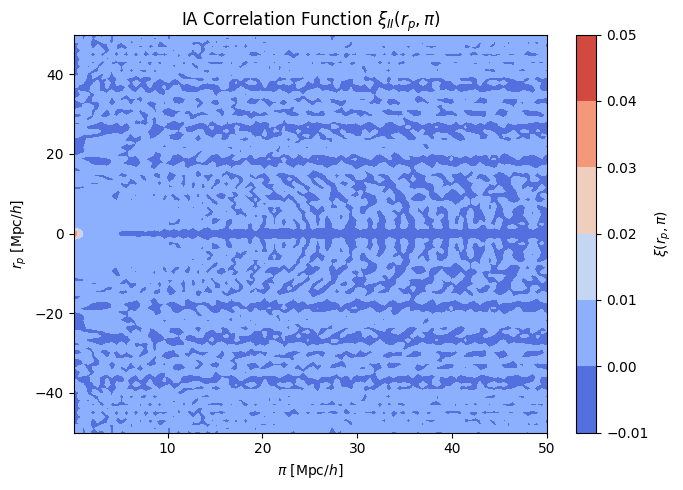

In [9]:
# Plot
plt.figure(figsize=(7, 5))
plt.contourf( rp_vals , pi_vals, xi_rppi.T, levels=5, cmap='coolwarm')
plt.colorbar(label=r'$\xi(r_p, \pi)$')
plt.xlabel(r'$\pi$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$r_p$ [$\mathrm{Mpc}/h$]')
plt.title('IA Correlation Function $\\xi_{II}(r_p, \pi)$')
plt.tight_layout()
plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_221948/70412645.py:46: SyntaxWarning: invalid escape sequence '\p'
  plt.title('GI Correlation Function $\\xi_{gI}(r_p, \pi)$')


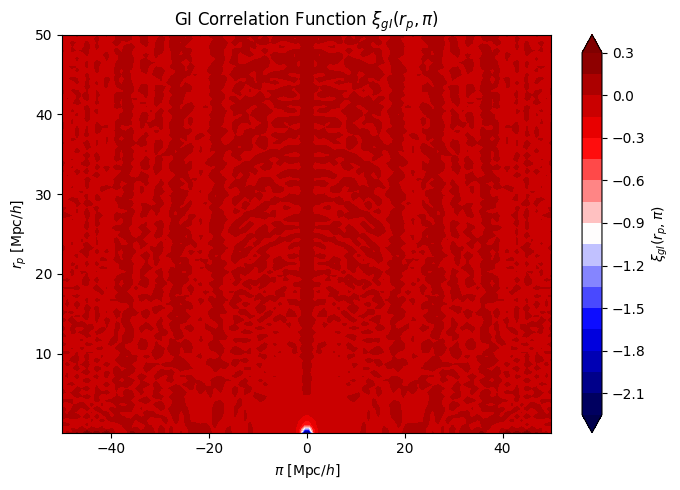

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.integrate import simpson

# Reuse previous cosmology and redshift setup
a = 1 / (1 + z)
k = np.logspace(-3, 1, 200)  # h/Mpc
mu = np.linspace(-1, 1, 100)
k2d, mu2d = np.meshgrid(k, mu, indexing='ij')

# Use the nonlinear alignment model
pk_m = ccl.nonlin_matter_power(cosmo, k, a)  # P_matter(k)
F_IA = -A_IA * C1 * rho_crit / ccl.growth_factor(cosmo, a)
P_gI = F_IA * pk_m  # GI model

# Extend to P(k, mu) (assuming isotropy, no RSD for now)
Pkm = np.tile(P_gI[:, None], (1, len(mu)))

# rp and pi grid
rp_vals = np.linspace(0.1, 50, 100)
pi_vals = np.linspace(-50, 50, 100)
rp_grid, pi_grid = np.meshgrid(rp_vals, pi_vals, indexing='ij')

xi_gi = np.zeros_like(rp_grid)

# Compute ξ_gI(rp, π)
for i in range(len(rp_vals)):
    for j in range(len(pi_vals)):
        rp = rp_vals[i]
        pi = pi_vals[j]
        r_par = pi
        J0 = j0(k2d * rp * np.sqrt(1 - mu2d**2))
        phase = np.cos(k2d * r_par * mu2d)
        integrand = k2d**2 * Pkm * phase * J0
        integ_mu = simpson(integrand, mu, axis=1)
        integ_k = simpson(integ_mu, k)
        xi_gi[i, j] = integ_k / (2 * np.pi**2)

# Plot ξ_gI(rp, π)
plt.figure(figsize=(7, 5))
plt.contourf(pi_vals, rp_vals, xi_gi, levels=20, cmap='seismic', extend='both')
plt.colorbar(label=r'$\xi_{gI}(r_p, \pi)$')
plt.xlabel(r'$\pi$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$r_p$ [$\mathrm{Mpc}/h$]')
plt.title('GI Correlation Function $\\xi_{gI}(r_p, \pi)$')
plt.tight_layout()
plt.show()
